<a href="https://colab.research.google.com/github/PRaezUC3M/cohort_selection/blob/master/RNN_with_TFID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(2)

# **Configurartion of the experiments**
The different possible experiments have been automated. It is inspired in grid-search, and the parameters must be expressed in array-like style. You can find an example below.

Every possible example will be generated from the combination of the different parameters given.

In [0]:
from keras.layers import LSTM, GRU
# best
# 200_rnn_size_64-64_dropout_0.5_fnn_size_256_batch_size_128
# Baseline Model
load_embeddings = [True, False] # This defines if the embeddings are loaded from the wikipedia dataset
num_classes = [None] # Auto
embeddings_size = [200]
rnn_size = [[64, 64]]
dropout = [0.5]
fnn_size = [[256]] #[[None]]
batch_size = [128]
cell_type = [GRU] # GRU
bidirectional = [False]
indexes = ["load_embeddings", "num_classes", "embeddings_size", "rnn_size", "cell_type", "bidirectional", "dropout", "fnn_size", "batch_size"]
param   = [load_embeddings, num_classes, embeddings_size, rnn_size, cell_type, bidirectional, dropout, fnn_size, batch_size]

Using TensorFlow backend.


In [0]:
import itertools

def combine_params(param, indexes):
  combinations = list(itertools.product(*param))
  param_combinations = [{k:v for k, v in zip(indexes, combination)}  for combination in combinations]
  for p in param_combinations:
    # The embeddings size must adapt to the embeddings loaded.
    if p["load_embeddings"]:
      p["embeddings_size"] = None
  return param_combinations

In [0]:
network_parameters = combine_params(param, indexes)
network_parameters

[{'batch_size': 128,
  'bidirectional': False,
  'cell_type': keras.layers.recurrent.GRU,
  'dropout': 0.5,
  'embeddings_size': None,
  'fnn_size': [256],
  'load_embeddings': True,
  'num_classes': None,
  'rnn_size': [64, 64]},
 {'batch_size': 128,
  'bidirectional': False,
  'cell_type': keras.layers.recurrent.GRU,
  'dropout': 0.5,
  'embeddings_size': 200,
  'fnn_size': [256],
  'load_embeddings': False,
  'num_classes': None,
  'rnn_size': [64, 64]}]

# **Load the train and test csv files**
This functions load the data and generate the different datasets from the given csv files. 

In [0]:
import pandas as pd
import numpy as np

SST_HOME='drive/My Drive/Colab Notebooks/CohortSelection/'
path_train=SST_HOME+'data/train/train.csv'
path_test=SST_HOME+'data/test/test.csv'

def load(path):
  
  df = pd.read_csv(path,header=0, delimiter="\t", quoting=3)

  categories=df.columns[2:]
  idFiles = df[['IDFILE']].as_matrix().tolist()

  texts = df[['TEXT']].as_matrix()
  X = [x[0].strip() for x in texts.tolist()]

  #we only keep the columns with the categories.
  Y = df.drop(['IDFILE', 'TEXT'], axis=1).as_matrix()


  print(path,'dataset loaded')
  
  return X, Y, categories, idFiles


train_x, train_y, CATEGORIES, _ = load(path_train)
test_x, test_y, _, IDFILES = load(path_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


drive/My Drive/Colab Notebooks/CohortSelection/data/train/train.csv dataset loaded
drive/My Drive/Colab Notebooks/CohortSelection/data/test/test.csv dataset loaded


#**Balancing the categories**
We can see that there are some categories way more present than others in our dataset. Let's sort them.

The categories are distributed in the following way


Text(0.5, 1.0, 'Criteria distribution on testing dataset')

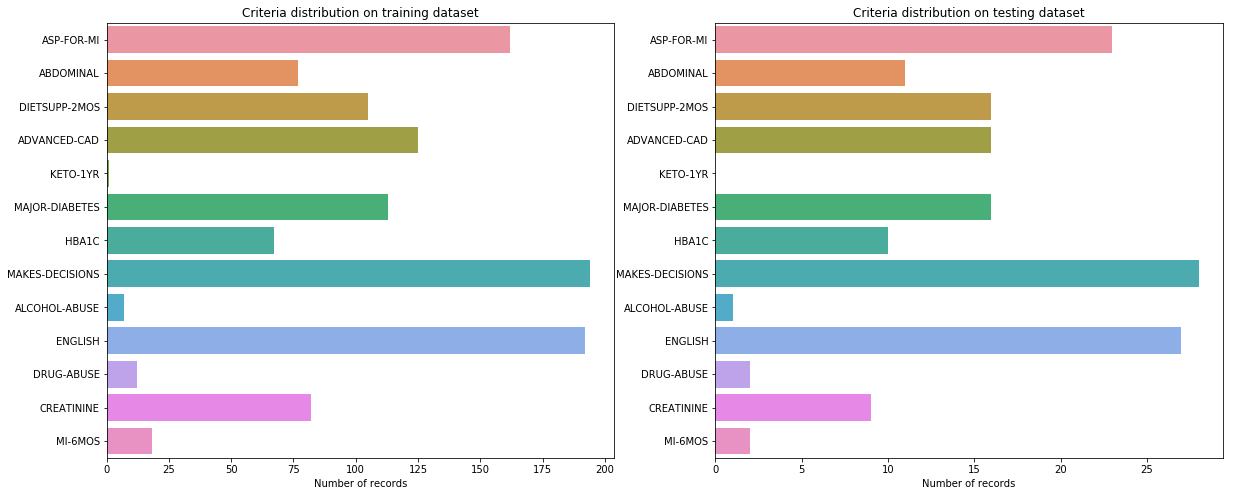

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns  

fig = plt.figure(figsize=(20,8))
(ax_train, ax_test) = fig.subplots(ncols=2, nrows=1)
g1 = sns.barplot(x=train_y.sum(axis=0), y=CATEGORIES, ax=ax_train)
ax_train.set_xlabel('Number of records')
g2 = sns.barplot(x=test_y.sum(axis=0), y=CATEGORIES, ax=ax_test)
ax_test.set_xlabel('Number of records')
g1.set_title("Criteria distribution on training dataset")
g2.set_title("Criteria distribution on testing dataset")

Now we can see the differences in a easier way, we will add weights to the different classes, based on how present they are in the dataset.

In [0]:
classes = np.add(sum(train_y), sum(test_y))
total_cases = sum(classes)
class_weight = [1 / (c/total_cases) for c in classes]

# **Tokenize the dataset and use the word embeddings**

This shows the set of different words ordered by frequency. *tokenizer.word_index*

The text is tokenized and cleaned of stop-words as well as punctuation signs. Also the numbers are substituted by a token "nmbr"

We crop the beggining of the examples because it is the date when they
were written down.

Finally, and after being tokenized, the different sentences are padded to match the maximum length.

max_length == 7813 it is really a huge vector because we have to pad
it afterwards, in order to get it into the CNN

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words=stopwords.words('english')
# Define maximum word length
MAX_WORDS = 5000
# Defined from the dataset itself.
DATE_LENGTH = 23

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# We are using this function to clean the test set
def tokenize_clean_text(text, tokenizer=None, max_length=None, 
                        max_words=MAX_WORDS, date_length=DATE_LENGTH):
  """
  This function is in charge of tokenizing the text it is given. It also cleans
  the text from stop-words, punctuation, and gives a special token to numbers.
  
  :param text: The texts to tokenize in a bidimensional python array.
  
  :returns: The tokenized and cleaned text in a bidimensional python array.
            The tokenizer used to preprocess the text.
            The maximum length used for padding.
  """  
  # Consider to stemm or lemmatize the text 
  
  cropped_date_text = [sentence[date_length:] for sentence in text]

  if max_length == None:
    # We get the maximum token length by splitting by spaces
    max_length = max([len(sentence[date_length:].split(" ")) for sentence in cropped_date_text])
    
  # We remove the numbers
  cropped_date_numbers_text = [" ".join([word if not word.isdigit() else ""
                                for word in sentence.split()])
                               for sentence in cropped_date_text]
  
  # Delete stopwords as well as every word less than 3 chars.
  cropped_date_numbers_stopw_text = [" ".join([word if not (word in stop_words or len(word) <= 3) else ""
                                      for word in sentence.split()])
                                     for sentence in cropped_date_numbers_text]
  
  vec = TfidfVectorizer(max_features=MAX_WORDS)
  tfidf_mat = vec.fit_transform(cropped_date_numbers_stopw_text).toarray()
  tfid_words = vec.get_feature_names()
  
  cropped_date_numbers_stopw_tfid_text = [" ".join([word if word in tfid_words else ""
                                          for word in sentence.split()])
                                          for sentence in cropped_date_numbers_stopw_text]

  if tokenizer is None:
    tokenizer = Tokenizer(num_words=MAX_WORDS) # They use 5k words too
    tokenizer.fit_on_texts(cropped_date_numbers_stopw_text)
  # We tokenize the sentences
  tokenized_text = tokenizer.texts_to_sequences(cropped_date_numbers_stopw_text)
  
  # Now we return the padded the sequences.
  return pad_sequences(tokenized_text, max_length), tokenizer, max_length
  

# RNN Input

Here we take a maximum length of file by obtaining the accumulative density distribution of the training examples. This way we can see how many examples fall under certain threshold. Which will be fixed to 80% of the total examples. This length is 5000 words roughly.

(array([ 21.,  61., 112., 159., 186., 195., 197., 199., 201., 202.]),
 array([ 905. , 1595.5, 2286. , 2976.5, 3667. , 4357.5, 5048. , 5738.5,
        6429. , 7119.5, 7810. ]),
 <a list of 10 Patch objects>)

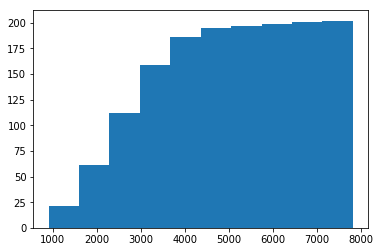

In [0]:
cropped_date_text = [sentence[DATE_LENGTH:] for sentence in train_x]
lenghts = [len(sentence[DATE_LENGTH:].split(" ")) for sentence in cropped_date_text]
plt.hist(lenghts, cumulative=True)

In [0]:
# Thus, we initialize the maximum word length as
max_length = 5000

In [0]:
train_x_token, tokenizer, max_length = tokenize_clean_text(train_x, max_length=max_length)
  
test_x_token, _, _ = tokenize_clean_text(test_x, tokenizer, max_length)
assert len(train_x_token) == len(train_x)
assert len(test_x_token) == len(test_x)

# **TensorBoard**
TensorBoard is a great tool for DL visualization. It shows the evolution of metrics during the training phase, as well as the weights, distributions, and even the graph of the neural net. 

We will be using tensorboardcolab in order to run a 
TensorBoard instance. This will initialize a ngrok machine and launch TensorBoard for us to see. 

TensorBoard will be accesible by the url 

In [0]:
# We install tensorboard colab in case we don't have it already.
!pip install tensorboardcolab

In [0]:
import tensorboardcolab as tb

tbc=tb.TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://9ebc6584.ngrok.io


# Load the embeddings

In this step, we load the word embeddings from the wikipedia, pubmed and PMC. Then we filter them adapting to the words we have in our dataset. This is, if the word appears in the pubmed we take its weights, which are set to 0 otherwise.

In [0]:
# seemingly gensim is not installed in google colab
!pip install gensim

In [0]:
from gensim.models.keyedvectors import KeyedVectors

PATH_W2V = "drive/My Drive/Colab Notebooks/CohortSelection/DL/word2vect/wikipedia-pubmed-and-PMC-w2v.bin"

In [0]:
def load_W2V_model(path):
    model = KeyedVectors.load_word2vec_format(path, binary=True)
    print("Loaded W2V model")
    return model
  
def generate_embedding_weigths(word_index, max_words, model):
  embedding_matrix = np.zeros((max_words, model.vector_size), dtype=np.float32)
  for word, i in word_index.items():
    if i >= max_words:
        break
    if word in model:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = model[word]
  return embedding_matrix

In [0]:
if not 'model' in locals():
  model = load_W2V_model(PATH_W2V)
# Generate the weights matrix
embedding_matrix = generate_embedding_weigths(tokenizer.word_index, MAX_WORDS, model)
for p in network_parameters:
  if p["load_embeddings"]:
    p["embeddings_size"] = model.vector_size

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Loaded W2V model


#**Create a keras Embedding model**

In this section we will create a Keras RNN model, compile, and train it.

In this model we can decide to generate the different embeddings for the words by using a pre-trained embeddings as the wikipedia ones for example.

Some information about the architecture of the net is shown bellow. 

In [0]:
import keras
from keras.models import Model
from keras.layers import Dense, Activation, Embedding, Dropout, Input
from keras.layers import LSTM, GRU, Bidirectional

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop

In [0]:
model_list = []
for net_param in network_parameters:
  inputs = Input(name='inputs',shape=(max_length,))
  
  # Add the embeddings
  if net_param["load_embeddings"]:
    z = Embedding(MAX_WORDS, net_param["embeddings_size"], input_length=max_length, weights=[embedding_matrix], trainable=False)(inputs)
  else:
    z = Embedding(MAX_WORDS, net_param["embeddings_size"], input_length=max_length)(inputs)
    
  for i, rsz in enumerate(net_param["rnn_size"]):
    if not net_param["bidirectional"]:
      if i < len(net_param["rnn_size"]) - 1:
        z = net_param["cell_type"](rsz, return_sequences=True)(z)
      else:
        z = net_param["cell_type"](rsz)(z)
    else:
      if i < len(net_param["rnn_size"]) - 1:
        z = Bidirectional(net_param["cell_type"](rsz, return_sequences=True))(z)
      else:
        z = Bidirectional(net_param["cell_type"](rsz))(z)
    
  for fsz in net_param["fnn_size"]:
    if fsz is None:
      break
    z = Dense(fsz)(z)
    z = Dropout(net_param["dropout"])(z)

  z = Dense(13,name='out_layer')(z)
  outputs = Activation('sigmoid')(z)

  net_model = Model(inputs=inputs,outputs=outputs)

  net_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


  # Print a summary of it.
  net_model.summary()
  model_list.append(net_model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 5000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 5000, 200)         1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 5000, 64)          50880     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)  

# TB Colab Callback
We rewrite the tensorboardcolab callbacks to create different sessions depending on the variables our trainings have. This helps to differentiate the models in tensorboard.

In [0]:
import os
from keras.callbacks import TensorBoard
import tensorflow as tf

class TensorBoardColabCallback(TensorBoard):
    def __init__(self, tbc=None, write_graph=True, name=None, **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'

        if tbc is None:
            return

        log_dir = tbc.get_graph_path()

        training_log_dir = os.path.join(log_dir, 'training_{}'.format(name))
        super(TensorBoardColabCallback, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation_{}'.format(name))

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TensorBoardColabCallback, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}

        for name, value in val_logs.items():
            # print('val_logs:',epoch, name, value)
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TensorBoardColabCallback, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TensorBoardColabCallback, self).on_train_end(logs)
        self.val_writer.close()

tb.TensorBoardColabCallback = TensorBoardColabCallback

In [0]:
def define_callbacks(name):
  # Define the callbacks
  tbc_callback = tb.TensorBoardColabCallback(tbc, name=name)
   
  callbacks = [
      ReduceLROnPlateau(),
      EarlyStopping(patience=4),
      tbc_callback
  ]
  return callbacks

In [0]:
# Create an array of names
network_names = []
for p in network_parameters:
  name = "tfid_load_embeddings_{}_num_classes_{}_embeddings_size_{}_rnn_size_{}_cell_type_{}_bidirectional_{}_dropout_{}_fnn_size_{}_batch_size_{}".format(
      p["load_embeddings"], p["num_classes"], p["embeddings_size"], p["rnn_size"], 
      str(p["cell_type"]).split(".")[-1].replace("'", "").replace(">", ""), p["bidirectional"],
      p["dropout"], p["fnn_size"], p["batch_size"])
  name = name.replace(" ", "").replace("[", "").replace("]", "").replace(",", "-")
  network_names.append(name)

In [0]:
from keras.models import load_model
for i, net_model in enumerate(model_list):
  # Set a name for the model based on the tweaked parameters
  p = network_parameters[i]
  name = network_names[i]
  model_path = SST_HOME+"DL/models/" + name

  # If the model exists, don't compute it again.
  if os.path.isfile(model_path):
    print("Already Trained Model: \n{}".format(name))
    net_model = load_model(model_path)
    net_model.summary()
    continue
    
  print("\n\n********************************************\n")    
  print(name)
  callbacks = define_callbacks(name)
  # Fit the model and extract its data
  history = net_model.fit(train_x_token, train_y, epochs=30, batch_size=network_parameters[i]["batch_size"], 
                          class_weight=class_weight, callbacks=callbacks,
                          validation_split=0.25)
      
  # And save the model
  net_model.save(model_path)
  
# To free memory from the gpu
from keras import backend as K
K.clear_session()

Already Trained Model: 
tfid_load_embeddings_True_num_classes_None_embeddings_size_200_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_256_batch_size_128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 5000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 5000, 200)         1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 5000, 64)          50880     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (No

# SKLearn Predictions

In [0]:
from sklearn.metrics import classification_report
predictions_list = []
for i, net_model in enumerate(model_list):
  print("\n\n********************************************\n")
  print(network_names[i])
  model_path = SST_HOME+"DL/models/" + network_names[i]
  try:
    net_model = load_model(model_path)
  except ValueError:
    print("The model {} was not loaded correctly".format(name))
    continue
    
  predictions = net_model.predict(test_x_token)
  predictions = np.array([[0 if value < 0.5 else 1 for value in prediction] for prediction in predictions])
  predictions_list.append(predictions)
  # measuring performance on test set
  cr=classification_report(test_y, predictions, target_names=CATEGORIES.values)
  print(cr)

  # Release memory
  K.clear_session()





********************************************

tfid_load_embeddings_True_num_classes_None_embeddings_size_200_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_256_batch_size_128


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/m

                 precision    recall  f1-score   support

     ASP-FOR-MI       0.77      1.00      0.87        23
      ABDOMINAL       0.00      0.00      0.00        11
  DIETSUPP-2MOS       0.79      0.69      0.73        16
   ADVANCED-CAD       0.53      1.00      0.70        16
       KETO-1YR       0.00      0.00      0.00         0
 MAJOR-DIABETES       0.53      1.00      0.70        16
          HBA1C       0.00      0.00      0.00        10
MAKES-DECISIONS       0.93      1.00      0.97        28
  ALCOHOL-ABUSE       0.00      0.00      0.00         1
        ENGLISH       0.90      1.00      0.95        27
     DRUG-ABUSE       0.00      0.00      0.00         2
     CREATININE       0.00      0.00      0.00         9
        MI-6MOS       0.00      0.00      0.00         2

      micro avg       0.74      0.75      0.74       161
      macro avg       0.34      0.44      0.38       161
   weighted avg       0.61      0.75      0.66       161
    samples avg       0.74   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/m

#**Generating output in XML format**



In [0]:
import xml.etree.ElementTree
import os
NOT='not met'
MET='met'

#gets a idFile, a dictionary with the predictions (category, label) and the name of the classifier used.
def outputToXML(idFile, dictPred, classifier):
    
    path=SST_HOME+'data/test/xml/'+idFile+'.xml'
    output_dir = SST_HOME+'data/output/'+classifier
    
    output = output_dir+'/'+idFile+'.xml'

    if not os.path.exists(output_dir):
      print("\n\nmaking dir")
      s = os.makedirs(output_dir)
      print(output_dir)
      print(s)      
   
    et = xml.etree.ElementTree.parse(path)

    new_tag = xml.etree.ElementTree.SubElement(et.getroot(), 'TAGS')
    
    for cat in dictPred.keys():
        element = xml.etree.ElementTree.SubElement(new_tag, cat)    
        if dictPred[cat]==0:
            element.attrib['met'] = NOT 
        else:
            element.attrib['met'] = MET

    et.write(output)

#function for creating a dictionary with the categories with values 0 or 1
def iniDictPred(labels, categories):
    
    if len(labels)!=len(categories):
        print('Warning!!!')
        return None
    
    dictPred={}
    i=0
    
    for x in categories:
        dictPred[x]=labels[i]
        i=i+1
    return dictPred

In [0]:
#creates the output xml files per training

for i, predictions in enumerate(predictions_list):
  dictionary = zip(IDFILES, predictions)
  for obj in dictionary:
      idFile=str(obj[0][0])
      labels=obj[1] #gets their predictions for this file
      dictPred=iniDictPred(labels, CATEGORIES) #creates a dictionary to join categories and labels 0,1
      outputToXML(idFile,dictPred,"RNN/{}".format(network_names[i]))

  print('output xml files were generated!')

output xml files were generated!
output xml files were generated!


In [0]:
import subprocess
# Writes the output in a file for each training.
for i, name in enumerate(network_names):
  print(name) 
  path = "data/output/RNN/"
  n = path + "{}".format(name)
  os.system('cd "{}" && echo "{}" {} {}results.txt'.format(SST_HOME, name, ">" if i == 0 else ">>", path))
  os.system('cd "{}" && python3 track1_eval.py data/test/gold {} >> {}results.txt'.format(SST_HOME, n, path))

tfid_load_embeddings_True_num_classes_None_embeddings_size_200_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_256_batch_size_128
tfid_load_embeddings_False_num_classes_None_embeddings_size_200_rnn_size_64-64_cell_type_GRU_bidirectional_False_dropout_0.5_fnn_size_256_batch_size_128
